# Trying Out Baseline with EfficentNetB1


## This notebook uses NIH Chest X-Ray dataset to learn and Predict Multiple Cateogry Dignosis from chest x-ray images. Please upvote if you like it.


## Outline
Use these links to jump to specific sections of this notebook!

- [1. Import Packages and Function](#1)
- [2. Load the Datasets](#2)
    - [2.1 Preventing Data Leakage](#2-1)
    - [2.2 Preparing Images](#2-2)
    - [2.3 Visualizing Images](#2-3)
- [3. Class Imbalence](#3)
    - [3.1 Addressing Class Imbalance](#3-1)
    - [3.2 Computing and Visualizing Class Imbalance](#3-2)
    - [3.3 Dealing with Class Imbalance](#3-3)
    - [3.4 Calculating the weighted loss](#3-4)
- [4. Model Creation](#4)
    - [4.1 Evaluating Pretrained Weights](#4-1)
    - [4.2 Training i.e. Fine Tuning](#4-2)
- [5. Prediction and Evaluation](#5)
    - [5.1 ROC Curve and AUROC](#5-1)
    - [5.2 Comparing ROC Curves](#5-2)
    - [5.3 Comparing AUROC Values](#5-3)
- [6. Saving Weights and Training History](#6)

<a name='1'></a>
## 1. Import Packages and Functions¶

We'll make use of the following packages:
- `numpy` and `pandas` is what we'll use to manipulate our data
- `matplotlib.pyplot` and `seaborn` will be used to produce plots for visualization
- `util` will provide the locally defined utility functions that have been provided for this assignment

We will also use several modules from the `keras` framework for building deep learning models.

Run the next cell to import all the necessary packages.

In [1]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Should return GPU model


True
Tesla P100-PCIE-16GB


In [2]:
!pip install tensorflow keras torch torchvision numpy pandas matplotlib seaborn


In [3]:

import random
import cv2
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


def get_roc_curve(labels, predicted_vals, generator, when = ''):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals
print('Done')

Done


In [4]:
from tensorflow.keras.applications import EfficientNetB0

model = EfficientNetB0(weights="imagenet")
print("EfficientNetB0 loaded successfully!")


21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB0 loaded successfully!


In [5]:
# Install EfficientNet
!pip install -q efficientnet

# Use TensorFlow's Keras API
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # ✅ Correct Import
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model

import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

print('Done')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00
Done


In [6]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


REPLICAS:  1


In [7]:
IMAGE_SIZE=[128, 128]
EPOCHS = 20
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 64


<a name='2'></a>
## 2. Load the Datasets

For this assignment, we will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
This dataset has been annotated by consensus among four different radiologists for 5 of our 14 pathologies:
- `Consolidation`
- `Edema`
- `Effusion`
- `Cardiomegaly`
- `Atelectasis`

In [8]:
train_df_main = pd.read_csv('../input/chestxray8-dataframe/train_df.csv')
# valid_df = pd.read_csv("nih/valid-small.csv")
# test_df = pd.read_csv("nih/test.csv")

train_df_main.drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main.columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [9]:
from sklearn.model_selection import train_test_split
train_df, discard = train_test_split(train_df_main, test_size = 0.7, random_state = 1993)

train_and_valid_set, test_set = train_test_split(train_df, test_size = 0.2, random_state = 1993)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = 1993)

<a name='2-1'></a>
### 2.1 Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.


<a name='Ex-1'></a>
### Exercise 1 - Checking Data Leakage
In the cell below, write a function to check whether there is leakage between two datasets. We'll use this to make sure there are no patients in the test set that are also present in either the train or validation sets.

In [10]:

def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups)>0 
    return leakage

<a name='2-2'></a>
### 2.2 Preparing Images
With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Keras documentation, we have implemented the generator for you. There are a few things to note: 
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be **320px by 320px

In [11]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect')
    
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator



#### Build a separate generator for valid and test sets

Now we need to build a new generator for validation and testing data. 

**Why can't we use the same generator as for the training data?**

Look back at the generator we wrote for the training data. 
- It normalizes each image **per batch**, meaning that it uses batch statistics. 
- We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). 
- Knowing the average per batch of test data would effectively give our model an advantage.  
    - The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics **computed from the training set**. 
* We implement this in the function below. 
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. 
* However, since this is extremely large, that would be very time consuming. 
* In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [12]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="FilePath", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    # batch = raw_train_generator.next()
    batch = next(raw_train_generator)

    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [13]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = None, 
                                      x_col = "FilePath",
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set, 
                                                              test_df = test_set, 
                                                              train_df = train_set,
                                                              image_dir = None, 
                                                              x_col = "FilePath", 
                                                              y_cols = labels,
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0], 
                                                              target_h = IMAGE_SIZE[1])

getting train generator...
Found 21476 validated image filenames.
getting train and valid generators...
Found 21476 validated image filenames.
Found 5370 validated image filenames.
Found 6712 validated image filenames.


<a name='2-3'></a>
### 2.3 Visualizing Images

Let's write a small function `get_label()` that will produce the class of the image as the appended string of the labels. 

100%|██████████| 8/8 [00:00<00:00, 64.42it/s]


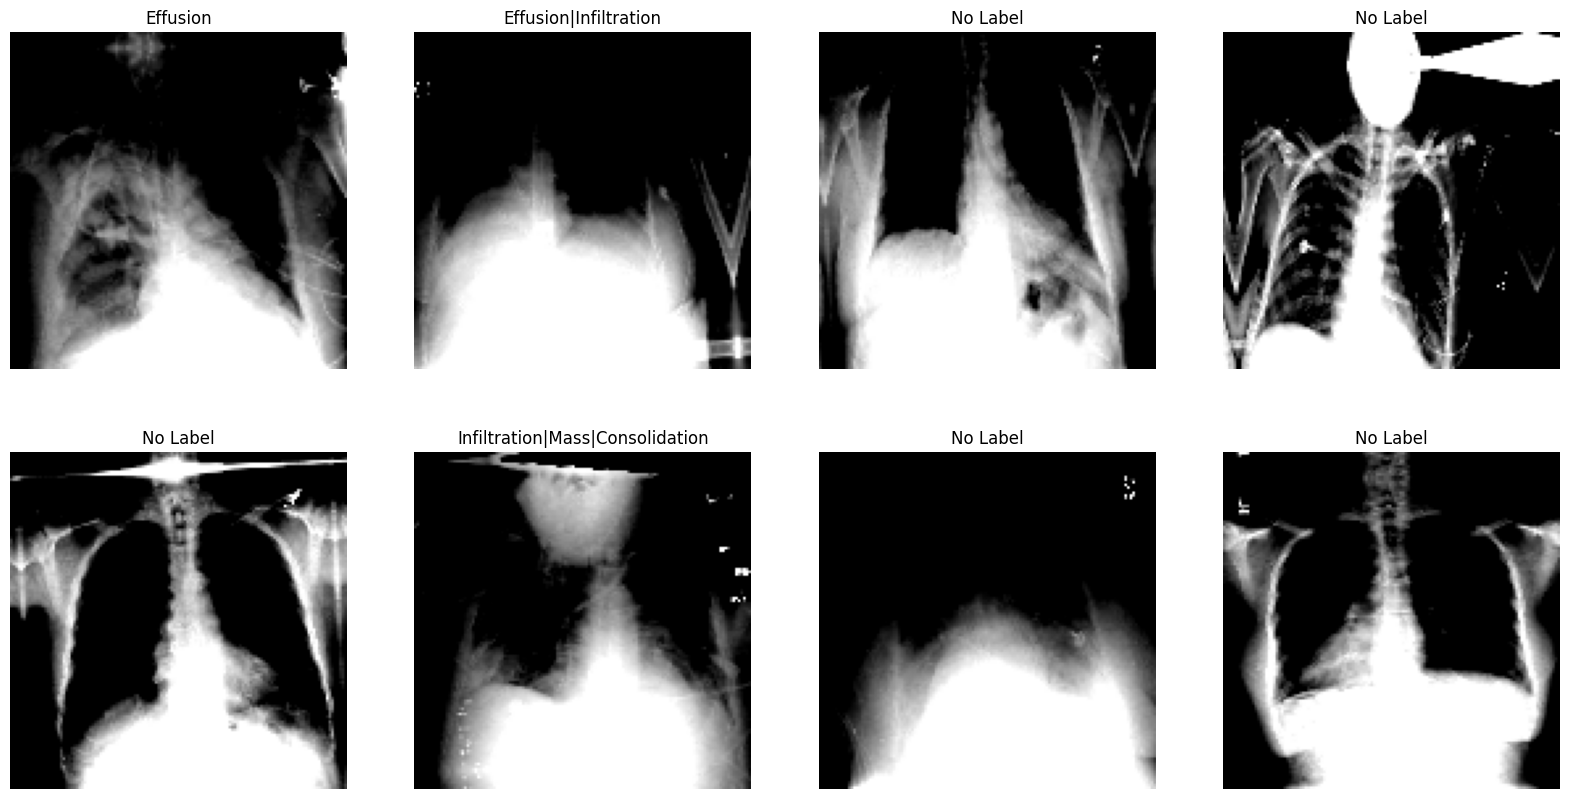

In [14]:

def get_label(y):
    """
    Returns the appended label list of the given set. 
    
    y(list) the one hot vector list containing the label encoding. 
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

#get one batch of images from the imageset    
x, y = train_generator.__getitem__(0)



#show a set of images along with the labels appended at the top as title.
fig=plt.figure(figsize=(20, 10))
columns = 4; rows =2 
for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i-1], cmap = 'gray')
    plt.title(get_label(y[i-1]))
    plt.axis(False)
    fig.add_subplot

<a name='3'></a>
## 3. Class Imbalence

Now we'll move on to model training and development. We have a few practical challenges to deal with before actually training a neural network, though. The first is class imbalance.

<a name='3-1'></a>
### 3.1 Addressing Class Imbalance
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Let's plot the frequency of each of the labels in our dataset:

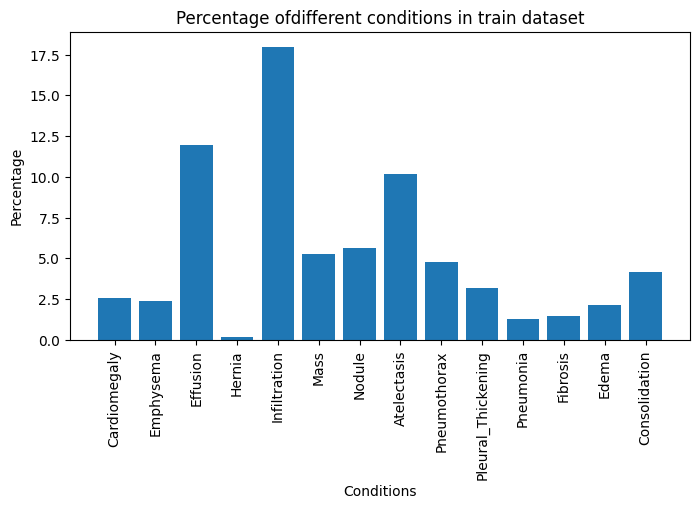

In [15]:
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. (These trends mirror the ones in the full dataset as well.) 
* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

If we use a normal cross-entropy loss function with a highly unbalanced dataset, as we are seeing here, then the algorithm will be incentivized to prioritize the majority class (i.e negative in our case), since it contributes more to the loss. 


#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

<a name='3-2'></a>
### 3.2 Computing and Visualizing Class Imbalance
Let's take the whole dataset and check the number of the different conditions identified among the x-rays. After that we plot the relative percentage of existance of different conditions in the image. 

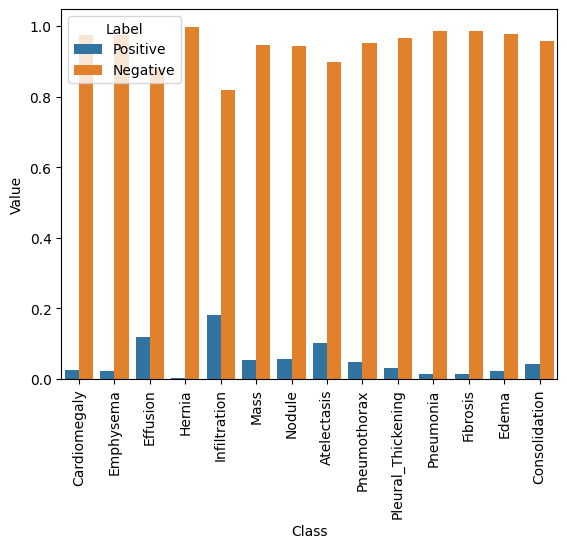

In [16]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequencies for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequencies for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis=0)) / N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# Calculating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

# Create initial DataFrame
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# Append new rows correctly using pd.concat()
new_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])
data = pd.concat([data, new_data], ignore_index=True)

# Plot results
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)


As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

Now lets balance the classes  and then use them for visualization 

<a name='3-3'></a>
### 3.3 Dealing with Class Imbalance

<Axes: xlabel='Class', ylabel='Value'>

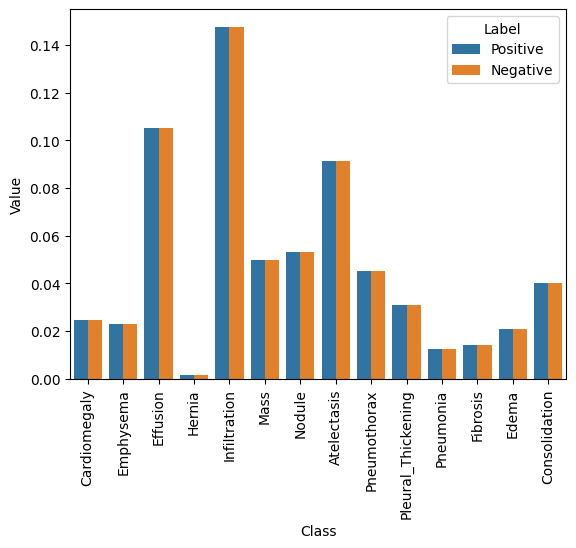

In [17]:
# Compute weights
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

# Create initial DataFrame
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Append new rows correctly using pd.concat()
new_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} 
                         for l,v in enumerate(neg_contribution)])
data = pd.concat([data, new_data], ignore_index=True)

# Plot results
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)


<a name='3-4'></a>
### 3.4 Calculating the weighted loss

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [18]:
import tensorflow.keras.backend as K  # ✅ Ensure correct import

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # Ensure numerical stability with tf.keras.backend functions
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(K.clip(y_pred[:, i], epsilon, 1.0)))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(K.clip(1 - y_pred[:, i], epsilon, 1.0)))
            loss += loss_pos + loss_neg

        return loss

    return weighted_loss


<a name=''>

<a name='4'> </a>
# 4. Model Creation
For the purpose of simplicity, we will use DenseNet121 model from the `keras.application` package. Then we will load the pretrained weights and have a look at the **ROC** curve and **AUROC** values for the different diagonostic categories. 

In [19]:
# with strategy.scope():
#     dnet121 = DenseNet121(input_shape=(*IMAGE_SIZE, 3),
#                           weights='imagenet',
#                           include_top=False )
#     dnet121.trainable = True

#     model_dnet121 = tf.keras.Sequential([ dnet121, 
#                                          Layers.GlobalAveragePooling2D(), 
#                                          Layers.Dense(len(labels), activation ='sigmoid') ])

#     model_dnet121.compile(optimizer='adam',
#                            loss = get_weighted_loss(pos_weights, neg_weights), 
#                            metrics = ['accuracy'] )`

#     model_dnet121.summary()

# history = model_dnet121.fit_generator(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=100, 
#                               validation_steps=25, 
#                               epochs = 3)

In [20]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB1(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dense(len(labels), activation='sigmoid')
    ])
    
model.compile(
    optimizer=tf.keras.optimizers.Adam( learning_rate=1e-4, amsgrad=False), 
    #loss = 'binary_crossentropy',
    loss = get_weighted_loss(pos_weights, neg_weights),
    metrics = ['accuracy']
)
model.summary()
model.load_weights('../input/nih-chest-xray-training-weights/efficent_net_b1_trained_weights.h5')

27164032/27164032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnet-b1 (Functional)         │ (None, 4, 4, 1280)          │       6,575,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │          14,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,901,326 (30.14 MB)

 Trainable params: 7,839,278 (29.90 MB)

 Non-trainable params: 62,048 (242.38 KB)

In [21]:
def build_lrfn(lr_start=0.000002, lr_max=0.00010, 
               lr_min=0, lr_rampup_epochs=8, 
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# This guide ensures that your model is saved persistently and can be resumed even if Kaggle unexpectedly stops.

Configuring kaggle.json for api verfication

In [22]:
!mkdir -p /root/.config/kaggle  # ✅ Create the directory if it doesn't exist
!cp /root/.kaggle/kaggle.json /root/.config/kaggle/  # ✅ Move the API key
!chmod 600 /root/.config/kaggle/kaggle.json  # ✅ Secure the API key


cp: cannot stat '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.config/kaggle/kaggle.json': No such file or directory


In [23]:
!ls /root/.config/kaggle/


In [24]:
!ls /root/.kaggle/


ls: cannot access '/root/.kaggle/': No such file or directory


In [25]:
!kaggle datasets list


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [26]:
pip install kaggle


Note: you may need to restart the kernel to use updated packages.


**Cleanup Code for Working Directory**

In [27]:
# import os
# import shutil

# # ✅ Define the working directory
# working_dir = "/kaggle/working/kaggle_saved_model"

# # ✅ Clean up working directory
# if os.path.exists(working_dir):
#     print(f"🧹 Cleaning up working directory: {working_dir}")
#     shutil.rmtree(working_dir)  # Delete the entire directory
#     os.makedirs(working_dir)  # Recreate the directory
#     print(f"✅ Working directory cleaned up and recreated: {working_dir}")
# else:
#     print(f"🚀 Working directory does not exist: {working_dir}")

**1️⃣ Modify ModelCheckpoint to Save in Kaggle’s Input Directory
Since /kaggle/input/ is read-only, we must automate dataset creation and saving.**

In [28]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define persistent save directory
checkpoint_dir = "/kaggle/working/my_saved_model"  # Temporary save location before moving
checkpoint_path = f"{checkpoint_dir}/model_checkpoint.keras"

# Ensure directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Set up automatic model checkpointing
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,  # ✅ Save full model (architecture + optimizer)
                             monitor='val_loss', 
                             mode='min', 
                             save_best_only=False,
                             verbose=1)


**2️⃣ Automate Moving the Model to Kaggle Dataset**

making metadata to save model checkpoints

In [29]:
# import os
# import json

# # ✅ Define the folder containing the files
# model_folder_path = "/kaggle/working/kaggle_saved_model"

# # ✅ Define the metadata content
# metadata = {
#     "title": "AutoSaved_Model",
#     "id": "zainali8/autosaved-model",
#     "licenses": [
#         {
#             "name": "Apache 2.0"
#         }
#     ]
# }

# # ✅ Define the path to the dataset-metadata.json file
# metadata_file_path = os.path.join(model_folder_path, "dataset-metadata.json")

# # ✅ Create the folder if it doesn't exist
# os.makedirs(model_folder_path, exist_ok=True)

# # ✅ Write the metadata to the file (create or override)
# with open(metadata_file_path, "w") as f:
#     json.dump(metadata, f, indent=4)

# print(f"✅ Successfully created/updated {metadata_file_path}")

**Coe to train model**

In [30]:
import shutil
import kaggle
import json
import os
import time
import tensorflow as tf

class KaggleAutoSave(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.dataset_dir = "/kaggle/working/kaggle_saved_model"  # Folder to save the model
        self.model_save_path = f"{self.dataset_dir}/model_checkpoint.keras"  # Consistent filename
        self.metadata_file_path = f"{self.dataset_dir}/dataset-metadata.json"  # Metadata file path

    def on_epoch_end(self, epoch, logs=None):
        """ Automatically saves and uploads the most recent model checkpoint to Kaggle. """
        
        # ✅ Ensure the folder exists
        os.makedirs(self.dataset_dir, exist_ok=True)

        # ✅ Delete the previous model checkpoint if it exists (working directory)
        if os.path.exists(self.model_save_path):
            os.remove(self.model_save_path)

        # ✅ Save the model with a consistent filename
        self.model.save(self.model_save_path)
        
        # ✅ Create or update dataset-metadata.json
        metadata = {
            "title": "AutoSaved_Model",
            "id": "zainali8/autosaved-model",
            "licenses": [
                {
                    "name": "Apache 2.0"
                }
            ]
        }
        with open(self.metadata_file_path, "w") as f:
            json.dump(metadata, f, indent=4)

        # ✅ Use your actual Kaggle username and dataset ID
        kaggle_username = "zainali8"  # 🔹 Your Kaggle username
        dataset_id = f"{kaggle_username}/autosaved-model"  # ✅ Match exact dataset name

        # ✅ Automate uploading to Kaggle Datasets with error handling
        try:
            kaggle.api.dataset_create_version(
                folder=self.dataset_dir,  # ✅ Path to the folder containing the files
                version_notes=f"Auto-saving model at epoch {epoch+1}",
                delete_old_versions=True  # ✅ Ensures only the latest model is kept on Kaggle
            )
            print(f"✅ Model successfully uploaded after epoch {epoch+1}")
        except Exception as e:
            print(f"❌ Failed to upload model after epoch {epoch+1}. Error: {e}")

# ✅ Add the auto-save callback to training
autosave_callback = KaggleAutoSave()

# Example usage with a model
EPOCHS = 10
history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator), 
    validation_steps=len(valid_generator), 
    epochs=EPOCHS,
    callbacks=[checkpoint, lr_schedule, autosave_callback]  # ✅ Auto-save enabled
)

OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/

# Automatically Resume Training When Session Restarts
Once Kaggle restarts, your notebook should automatically detect the saved model and resume training.

1️⃣ Attach the Auto-Saved Dataset
Click "Add Data" (Right Panel).
Search for auto-saved-model and attach it.

In [ ]:
import os
from tensorflow.keras.models import load_model

# ✅ Define the path to the saved model
saved_model_path = "/kaggle/input/auto-saved-model/model_checkpoint.keras"

# ✅ Check if saved model exists
if os.path.exists(saved_model_path):
    print("✅ Loading saved model to resume training...")
    model = load_model(saved_model_path)
    
    # ✅ Determine the initial epoch from the optimizer's iterations
    initial_epoch = model.optimizer.iterations.numpy() // len(train_generator)
    print(f"Resuming training from epoch {initial_epoch}")
else:
    print("🚀 No previous model found. Starting fresh.")
    initial_epoch = 0

# ✅ Resume training
history = model.fit(
    train_generator, 
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator), 
    validation_steps=len(valid_generator), 
    initial_epoch=initial_epoch,  # ✅ Resume from last epoch
    epochs=EPOCHS,
    callbacks=[checkpoint, lr_schedule, autosave_callback]  # ✅ Save checkpoints during training
)

Summary (Fully Automated Process)
1️⃣ Auto-Saving (No Manual Work)
After each epoch, the model is automatically uploaded to a Kaggle dataset.
If the session crashes, the model is already saved.
2️⃣ Auto-Resuming (No Manual Work)
When Kaggle restarts, it automatically loads the last saved model.
Training resumes from the last completed epoch.
🚀 Now, even if the session closes unexpectedly, training will continue seamlessly! 🚀🔥

Let me know if you need further tweaks! 😊

without auto  save

In [ ]:
# history = model.fit(train_generator, 
#                     validation_data=valid_generator,
#                     steps_per_epoch=len(train_generator), 
#                     validation_steps=len(valid_generator), 
#                     epochs=EPOCHS,
#                     callbacks=[lr_schedule]
#                    )


In [ ]:
predicted_vals_before = model.predict_generator(test_generator, steps = len(test_generator))

In [ ]:


history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=len(train_generator), 
                              validation_steps=len(valid_generator), 
                              epochs = EPOCHS,
                              callbacks=[lr_schedule]
                             )

In [ ]:
# # create the base pre-trained model
# base_model = DenseNet121(weights='imagenet', include_top=False)
# # base_model = DenseNet121(weights='../input/chestxray8-dataframe/pretrained_model.h5', include_top=False)

# x = base_model.output
# # add a global spatial average pooling layer
# x = GlobalAveragePooling2D()(x)

# # and a logistic layer
# predictions = Dense(len(labels), activation="sigmoid")(x)

# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])
# #Loading the pretrained weights from the custom dataset
# model.load_weights('../input/chestxray8-dataframe/pretrained_model.h5')
# predicted_vals_before = model.predict_generator(test_generator, steps = len(test_generator))



# history = model.fit_generator(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=len(train_generator), 
#                               validation_steps=len(valid_generator), 
#                               epochs = 5)

Now let's train the model for a few epochs. 

## Training Summary

In [ ]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()

In [ ]:
visualize_training(history)

<a name='5'></a>
## 5. Prediction and Evaluation
Now that we have a model, let's evaluate it using our test set. We can conveniently use the `predict_generator` function to generate the predictions for the images in our test set.

<a name='5-1'></a>
### 5.1 ROC Curve and AUROC
We'll cover topic of model evaluation in much more detail in later weeks, but for now we'll walk through computing a metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. This is also referred to as the AUROC value, but you will see all three terms in reference to the technique, and often used almost interchangeably. 

For now, what you need to know in order to interpret the plot is that a curve that is more to the left and the top has more "area" under it, and indicates that the model is performing better.

We will use the `util.get_roc_curve()` function which has been provided for you in `util.py`. Look through this function and note the use of the `sklearn` library functions to generate the ROC curves and AUROC values for our model. 

- [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

<a name='5-2'></a>
### 5.2 Comparing ROC Curves

In [ ]:
predicted_vals_after = model.predict_generator(test_generator, steps = len(test_generator))
auc_rocs_before =get_roc_curve(labels, predicted_vals_before, test_generator, when = 'before training')
auc_rocs_after = get_roc_curve(labels, predicted_vals_after, test_generator, when = 'after training')

<a name='5-3'></a>
## 5.3 Comparing AUROC Values
Now lets have a look at the change of individual **ROCAUC** change after training the network. 

In [ ]:
ind = np.arange(len(labels))
plt.figure(figsize=(15,7))
width = 0.2       
plt.bar(ind, auc_rocs_before , width, label='Before')
plt.bar(ind + width, auc_rocs_after, width, label='After')
plt.ylabel('AUROC value', fontsize = 16)
plt.title('AUROC of each diagnosis before and after training', fontsize = 18)
plt.xticks(ind + width / 2, labels, rotation = 90, fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='best')
plt.grid(True)
plt.show()

<a name='6'></a>
# 6. Saving Weights and Training History
Let's save the newly trained weights and the trainigng history for the future use. 

In [ ]:
model.save_weights('efficent_net_b1_trained_weights.h5')
pd.DataFrame.from_dict(history.history).to_csv('efficent_net_b1_training_hisotry.csv', index = False)